In [2]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes

import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn import model as modellib, utils

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

Using TensorFlow backend.


In [3]:
print(os.getenv("CUDA_VISIBLE_DEVICES"))

None


In [4]:
class SchoolsConfig(Config):
    """Configuration for training on the dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "schools"
    
    # Train on 1 GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    # Number of classes (including background)
    NUM_CLASSES = 1 + 5  # Background 
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 10
    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

config = SchoolsConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                18
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [5]:
class SchoolsDataset(utils.Dataset):

    def load_schools(self, dataset_dir, subset):
        """Load a subset of the Horse-Man dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("schools", 1, "building")
        self.add_class("schools", 2, "bush")
        self.add_class("schools", 3, "concrete")
        self.add_class("schools", 4, "grass")
        self.add_class("schools", 5, "tree")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        annotations = json.load(open(os.path.join(dataset_dir, "annots.json")))
        #print(annotations)
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
        
        # Add images
        for a in annotations:
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions'].values()] 
            
            schools = [s['region_attributes'] for s in a['regions'].values()]


            #name_dict = {"building": 1,"bush": 2,"concrete": 3, "grass": 4, "tree": 5}
            # key = tuple(name_dict)
            num_ids = []

            for school in schools:
                try: 
                    if school['label'] == "building":
                        num_ids.append(1)
                    elif school['label'] == "bush":
                        num_ids.append(2)
                    elif school['label'] == "concrete":
                        num_ids.append(3)
                    elif school['label'] == "grass":
                        num_ids.append(4)
                    elif school['label'] == "tree":
                        num_ids.append(5)
                except:
                    pass
     
            # num_ids = [int(n['Event']) for n in objects]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            # print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "schools",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a custom dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "schools":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = image_info['num_ids']	

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        num_ids = np.array(num_ids, dtype=np.int32)	
        return mask, num_ids#.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32), 


    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "schools":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

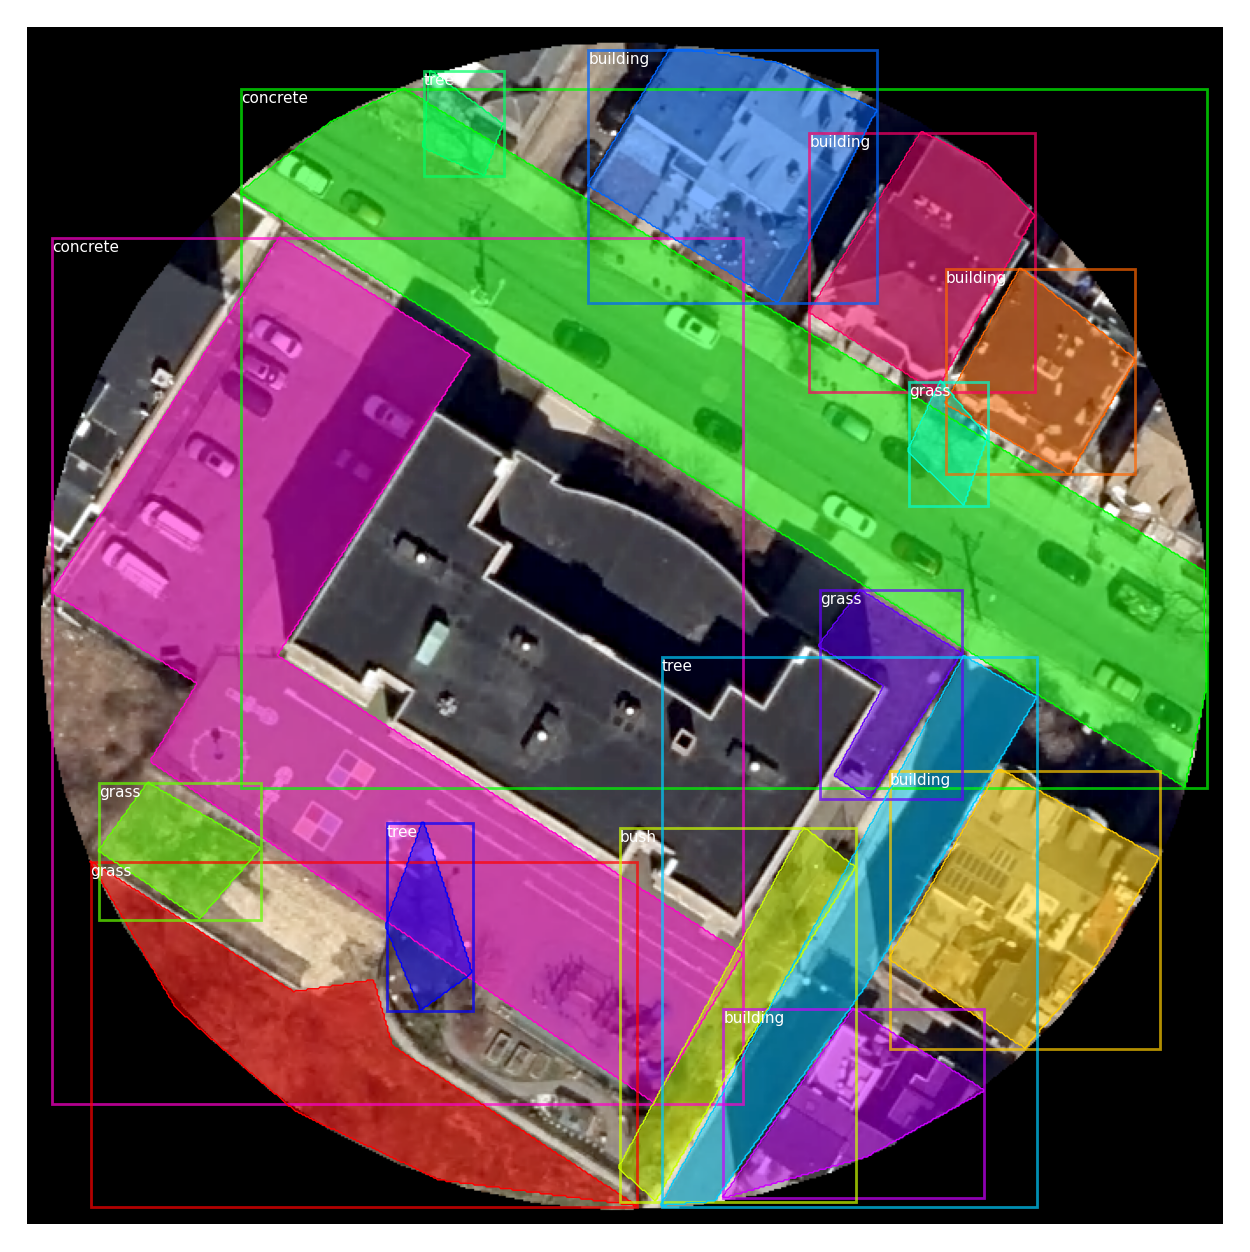

In [8]:
dataset_train = SchoolsDataset()
dataset_train.load_schools("schools/", "train") 
dataset_train.prepare()

# define image id
image_id = 0
# load the image
image = dataset_train.load_image(image_id)
# load the masks and the class ids
mask, class_ids = dataset_train.load_mask(image_id)

# display_instances(image, r1['rois'], r1['masks'], r1['class_ids'],
# dataset.class_names, r1['scores'], ax=ax, title="Predictions1")

# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, dataset_train.class_names)

In [ ]:
model = MaskRCNN(mode='training', model_dir=DEFAULT_LOGS_DIR, config=config)
# load weights (mscoco) and exclude the output layers
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
# train weights (output layers or 'heads')
model.train(dataset_train, dataset_train, learning_rate=config.LEARNING_RATE, epochs=25, layers='heads')

: 

In [17]:
import time
def train(model):
    start_time = time.time()
    # Load training dataset
    dataset_train = SchoolsDataset()
    dataset_train.load_schools("schools", "train")
    dataset_train.prepare()

    # Load testing dataset
    # dataset_val = SchoolsDataset()
    # dataset_val.load_schools("schools", "val")
    # dataset_val.prepare()

    print("Training in process...")
    model.train(dataset_train, dataset_train,
                learning_rate=config.LEARNING_RATE,
                epochs=10, 
                layers="head")
    end_time = time.time()
    minutes = round((end_time-start_time)/60, 2)
    print(f"Training took {minutes} to bcomplete.")

In [18]:
model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=DEFAULT_LOGS_DIR)

model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])
train(model)

2023-03-30 21:55:30.824554: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr4/ugrad/cjxu/.local/lib/python3.8/site-packages/cv2/../../lib64:
2023-03-30 21:55:30.824645: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-30 21:55:30.824704: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (scc1): /proc/driver/nvidia/version does not exist
2023-03-30 21:55:30.914158: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2023-03-30 21:55:30.968040: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2800000000 Hz
2023-03-30 21:55:30.970451: I tensorflow/compiler/xla/service/service.cc:16

Training in process...

Starting at epoch 0. LR=0.001

Checkpoint Path: /usr4/ugrad/cjxu/logs/schools20230330T2155/mask_rcnn_schools_{epoch:04d}.h5
Selecting layers to train
In model:  rpn_model


2023-03-30 21:55:35.098381: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session started.


ValueError: inputs must be a list of at least one Tensor/IndexedSlices with the same dtype and shape